In [3]:
import numpy as np
import pandas as pd
import yfinance as yf
from numpy.ma.core import resize
from scipy.stats import t
from datetime import datetime, timedelta
import time
import matplotlib.pyplot as plt
import pyextremes as pyx
from arch import arch_model
from statsmodels.stats.diagnostic import (acorr_ljungbox)
import statsmodels.api as sm

In [ ]:
def get_doge_data():
    doge_yf = yf.download("DOGE-USD", start="2014-01-01", interval="1d")
    print(doge_yf)

    doge_data = pd.read_csv("doge_data.csv")
    doge_data['Date'] = pd.to_datetime(doge_data['Timestamp'])
    print(doge_data)

    result_dataset = pd.DataFrame()
    for i in range(0, len(doge_data)):
        # print(doge_data.iloc[i])
        if (doge_data.iloc[i]['Date'] < pd.to_datetime('2017-11-09 00:00:00.000')):
            new_entry = {'Date': doge_data.iloc[i]['Date'], 'Price': doge_data.iloc[i]['Price']}
            result_dataset = pd.concat([result_dataset, pd.DataFrame([new_entry])], ignore_index=True)

    doge_yf = doge_yf.reset_index()

    # Now select only the 'Date' and 'Close' columns
    doge_date_close = doge_yf[['Date', 'Close']]
    doge_date_close.columns = doge_date_close.columns.droplevel(level=1)
    print(doge_date_close.head())

    for i in range(0, len(doge_date_close)):
        new_entry = {'Date': doge_date_close.iloc[i]['Date'], 'Price': doge_date_close.iloc[i]['Close']}
        # print(new_entry)
        result_dataset = pd.concat([result_dataset, pd.DataFrame([new_entry])], ignore_index=True)

    current = pd.to_datetime('2013-12-15 00:00:00.00')
    cnt = 0
    print(len(result_dataset))
    for i in range(0, len(result_dataset)):
        if (result_dataset.iloc[i]['Date'] != current):
            cnt += 1
            i -= 1
            print(current)
        current = current + pd.Timedelta(days=1)
    print(cnt)
    result_dataset.to_csv('doge_daily_data.csv', index=False)
    print(result_dataset)

#get_doge_data()

[*********************100%***********************]  1 of 1 completed


Price          Close      High       Low      Open      Volume
Ticker      DOGE-USD  DOGE-USD  DOGE-USD  DOGE-USD    DOGE-USD
Date                                                          
2017-11-09  0.001415  0.001415  0.001181  0.001207     6259550
2017-11-10  0.001163  0.001431  0.001125  0.001421     4246520
2017-11-11  0.001201  0.001257  0.001141  0.001146     2231080
2017-11-12  0.001038  0.001210  0.001002  0.001189     3288960
2017-11-13  0.001211  0.001212  0.001019  0.001046     2481270
...              ...       ...       ...       ...         ...
2025-05-31  0.192579  0.195352  0.186063  0.193442  1529424800
2025-06-01  0.193632  0.194780  0.187268  0.192578   939280532
2025-06-02  0.195390  0.196065  0.188872  0.193632  1007324701
2025-06-03  0.193138  0.200251  0.192190  0.195396  1062603805
2025-06-04  0.191375  0.196810  0.190368  0.193152   857660992

[2765 rows x 5 columns]
                    Timestamp     Price        Volume    Market Cap       Date
0     2013-12-

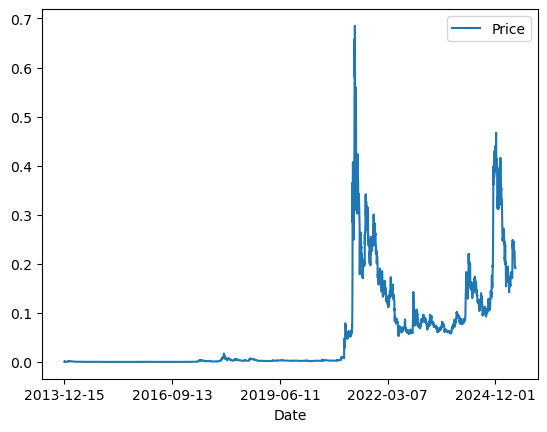

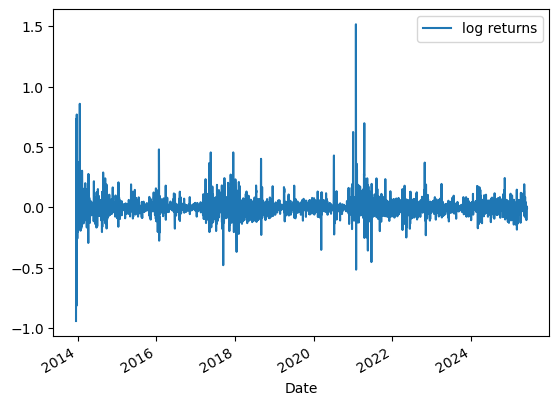

In [43]:
# functions

doge_data = pd.read_csv("../data/doge_daily_data.csv")
doge_data.set_index("Date", inplace=True)
doge_data.plot(label="Doge Price")
plt.legend()

log_doge_returns = np.log(doge_data / doge_data.shift(1)).dropna()
log_doge_returns = log_doge_returns['Price']
log_doge_returns.index = pd.to_datetime(log_doge_returns.index)
plt.figure()
log_doge_returns.plot(label="log returns")
plt.legend()


def hill_estimator(data, k):
    log_data = np.log(data[:k])
    return (1/k) * np.sum(log_data) - np.log(data[k])

def pickands_estimator(data, k):
    if 4*k >= len(data):
        return np.nan
    return 1/np.log(2) * np.log((data[k] - data[2*k])/(data[2*k] - data[4*k]))

def threshold_picking(data0):
    data = -data0[data0 < 0]
    pyx.plot_mean_residual_life(data)

    # Mean residual life plot plots average excess value over given threshold for a series of thresholds.
    # The idea is that the mean residual life plot should be approximately linear above a threshold for    
    # which the Generalized Pareto Distribution model is valid.

    datas = np.sort(data)[::-1]
    k_values = range(4, len(datas)//2)

    hill_estimates = [hill_estimator(datas, k) for k in k_values]
    plt.figure(figsize=(10,6))
    plt.plot(k_values, hill_estimates, 'b-')
    plt.xlabel("k_values")
    plt.ylabel("hill estimates")

    pickands_estimates = [pickands_estimator(datas, k) for k in k_values]
    plt.figure(figsize=(10,6))
    plt.plot(k_values, pickands_estimates, 'r-', label="Pickands' ξ")
    plt.xlabel("k_values")
    plt.ylabel("pickands' estimates")

    # Parameter stability plot shows how shape and modified scale parameters of the Generalized
    # Pareto Distribution change over a range of threshold values. The idea is that these parameters
    # should be stable (vary by small amount) within a range of valid thresholds.

    pyx.plot_parameter_stability(log_doge_returns)
    plt.title("Parameter stability plot")
    plt.show()
    return datas

def modeling(data0, u):
    data = -data0[data0 < 0]
    model = pyx.EVA(data)
    model.get_extremes(method="POT", threshold=u)
    model.fit_model(distribution="genpareto")
    print(model.model)
    model.plot_diagnostic()

    params = model.model.fit_parameters
    print(params)
    xi = params['c']
    sig = params['scale']
    return xi, sig

def prediction(params, data, u, level):
    xi = params[0]
    sig = params[1]
    data = -data
    p = level
    n_total = len(data)
    n_exceed = len([i for i in data if i > u])
    F_u = n_exceed / n_total # probability of exceeding the threshold u
    print("Violation ratio: ", F_u)
    p_u = F_u / p
    VaR = u + (sig / xi) * (p_u ** xi - 1)
    ES = ES = (VaR + (sig - xi * u)/xi) / (1 - xi)
    return VaR, ES

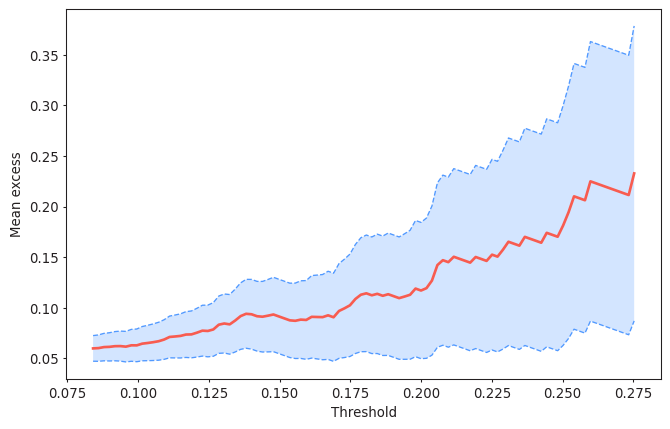

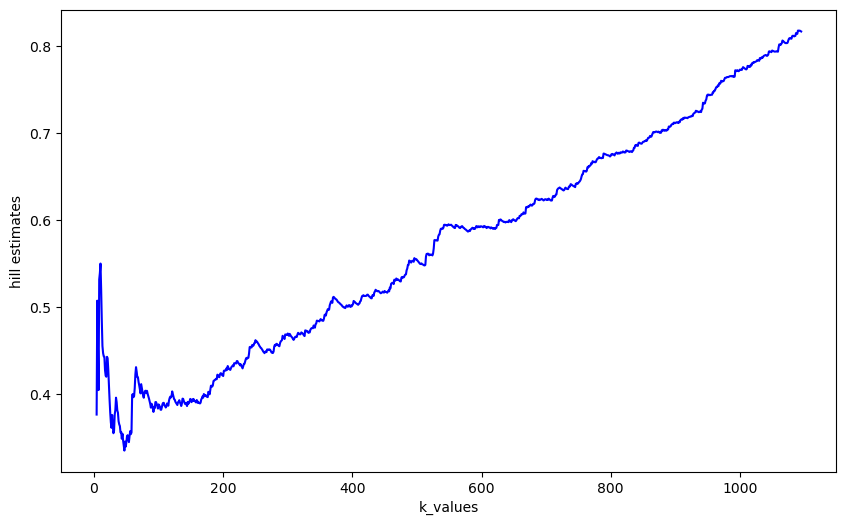

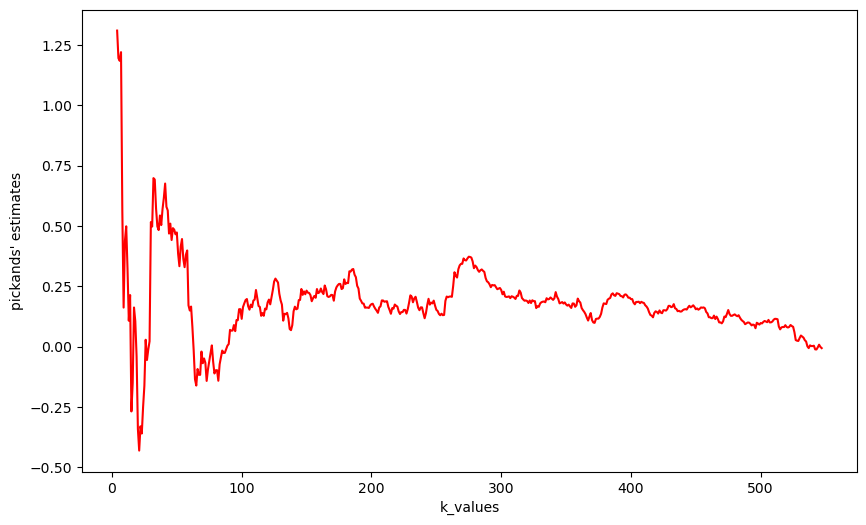

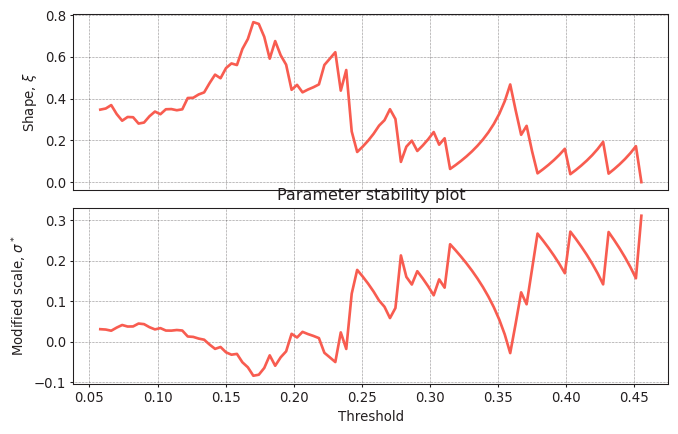

In [42]:
sorted_static_doge = threshold_picking(log_doge_returns)

(<Axes: ylabel='Shape, $\\xi$'>,
 <Axes: ylabel='Modified scale, $\\sigma^*$'>,
 <Axes: ylabel='Return value'>,
 <Axes: xlabel='Threshold', ylabel='AIC Score'>)

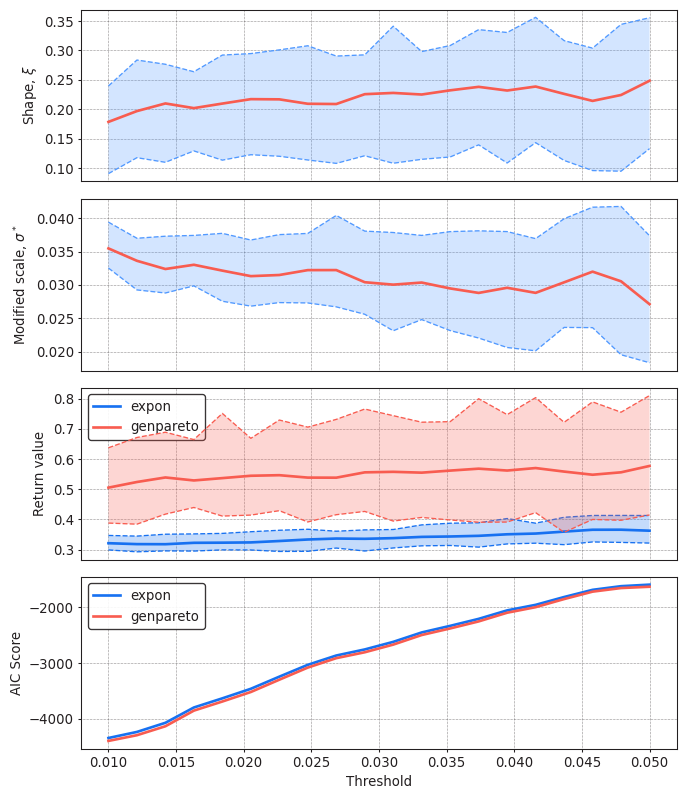

In [40]:
pyx.plot_threshold_stability(log_doge_returns, return_period=10, alpha=0.95, thresholds=np.linspace(0.01, 0.05, 20))
#u = 0.02

# pyextremes provides a convenience function to put all of the above together. It also adds an
# additional plot - AIC curve indicating relative model performance. The AIC curve should not
# be used as a threshold selection tool because it will always have the same logarithmic shape.
# Instead, it should guide the user as to which model (e.g. GEVD or Exponential) should be preferred
# for a given threshold.


0.13560013595447637
              MLE model              
-------------------------------------
free parameters: c=0.322, scale=0.063
fixed parameters: floc=0.136         
AIC: -185.897                        
loglikelihood: 95.044                
return value cache size: 0           
fit parameter cache size: 0          
-------------------------------------
{'c': 0.3223884012259606, 'scale': 0.0631311894820401}


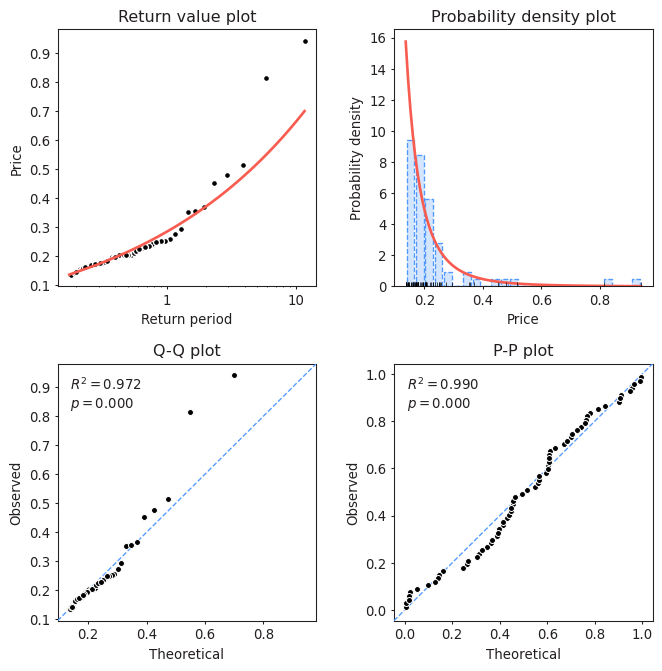

In [44]:
u_static_doge = sorted_static_doge[70]
print(u_static_doge)
params_static_doge = modeling(log_doge_returns, u_static_doge)

In [45]:
VaR_static_doge, ES_static_doge = prediction(params_static_doge, log_doge_returns, u_static_doge, level=0.01)
print(VaR_static_doge, ES_static_doge)

Violation ratio:  0.016726403823178016
0.1709230556900791 0.3411191746291591


Iteration:      5,   Func. Count:     36,   Neg. LLF: 3391.8764701993155
Iteration:     10,   Func. Count:     65,   Neg. LLF: 3384.329676897348
Iteration:     15,   Func. Count:    105,   Neg. LLF: 8154.517297342098
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3384.277970519297
            Iterations: 19
            Function evaluations: 130
            Gradient evaluations: 17
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  Price   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3384.28
Distribution:                  Normal   AIC:                           6776.56
Method:            Maximum Likelihood   BIC:                           6801.91
                                        No. Observations:                 4185
Date:               

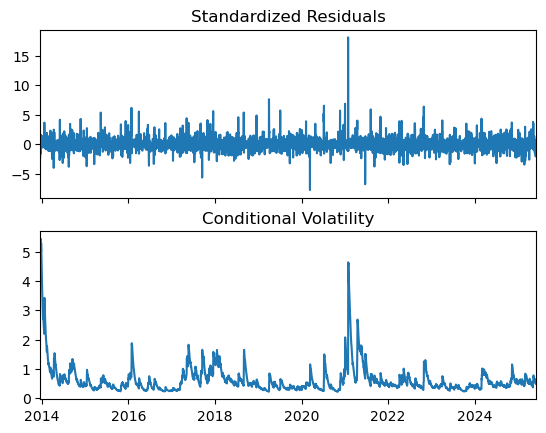

Ljung-Box test on residuals:
   lb_stat  lb_pvalue
1   0.9617   0.326759
Ljung-Box test on squared residuals:
    lb_stat  lb_pvalue
1  2.477169    0.11551
Model is adequate (no remaining ARCH effects).


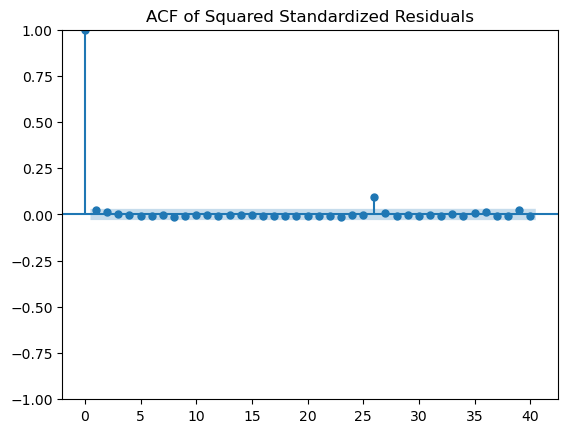

In [80]:
# Two-step process: Fit GARCH(1,1) model, use EVT
doge_model = arch_model(10 * log_doge_returns, vol='Garch', p=1, q=1, mean="Constant")
results = doge_model.fit(update_freq = 5)
print(results.summary())
results.plot()
plt.show()
standardized_resid = results.resid / results.conditional_volatility

# Ljung-Box test (lag 10 as example)
ljung_box = acorr_ljungbox(standardized_resid, lags=1, return_df=True)
print("Ljung-Box test on residuals:")
print(ljung_box)

squared_resid = standardized_resid**2
lb_test_squared = acorr_ljungbox(squared_resid, lags=1, return_df=True)
print("Ljung-Box test on squared residuals:")
print(lb_test_squared)

if lb_test_squared["lb_pvalue"].iloc[0] > 0.05:
    print("Model is adequate (no remaining ARCH effects).")
else:
    print("Model is inadequate (try EGARCH or higher-order GARCH).")

# Step 3: Plot ACF
sm.graphics.tsa.plot_acf(squared_resid, lags=40)
plt.title('ACF of Squared Standardized Residuals')
plt.show()

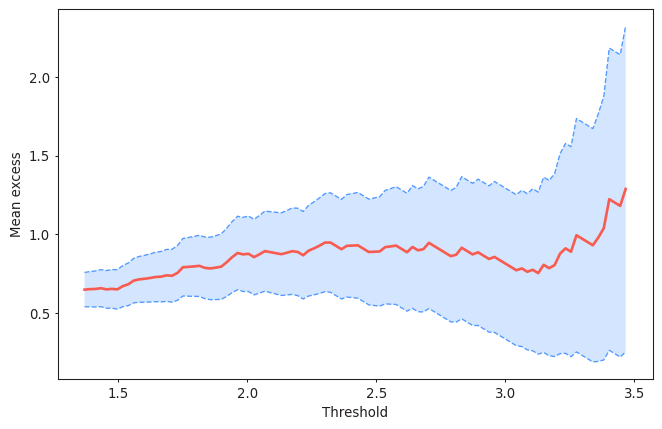

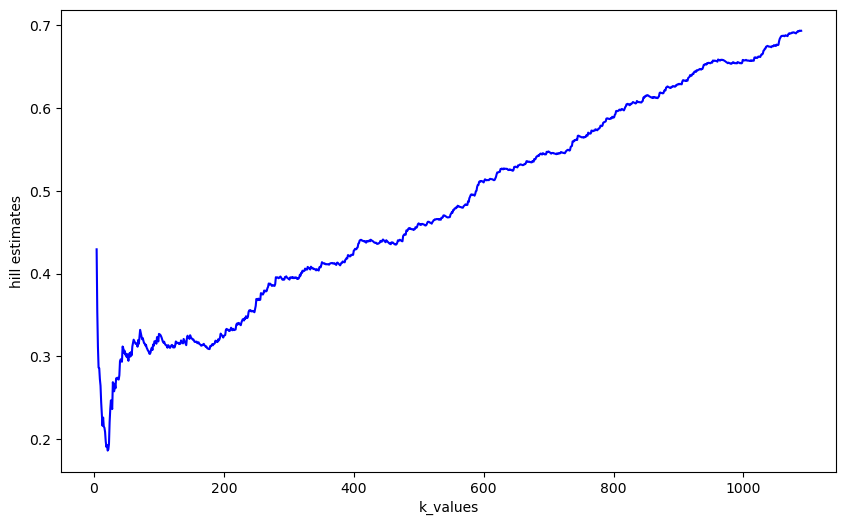

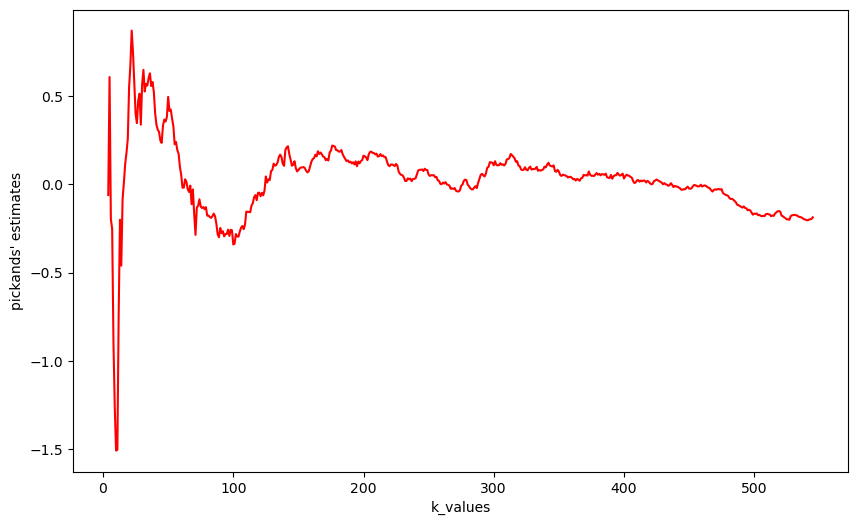

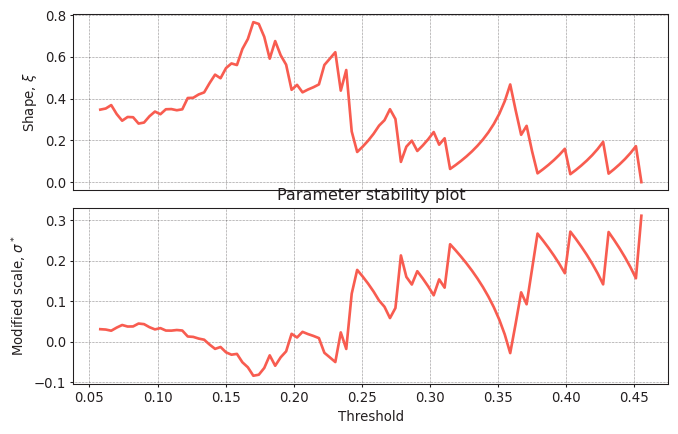

In [81]:
sorted_dynamic_doge = threshold_picking(standardized_resid)

1.979985719252526
              MLE model              
-------------------------------------
free parameters: c=0.108, scale=0.783
fixed parameters: floc=1.980         
AIC: 123.451                         
loglikelihood: -59.635               
return value cache size: 0           
fit parameter cache size: 0          
-------------------------------------
{'c': 0.10837442859195062, 'scale': 0.7833800018804378}


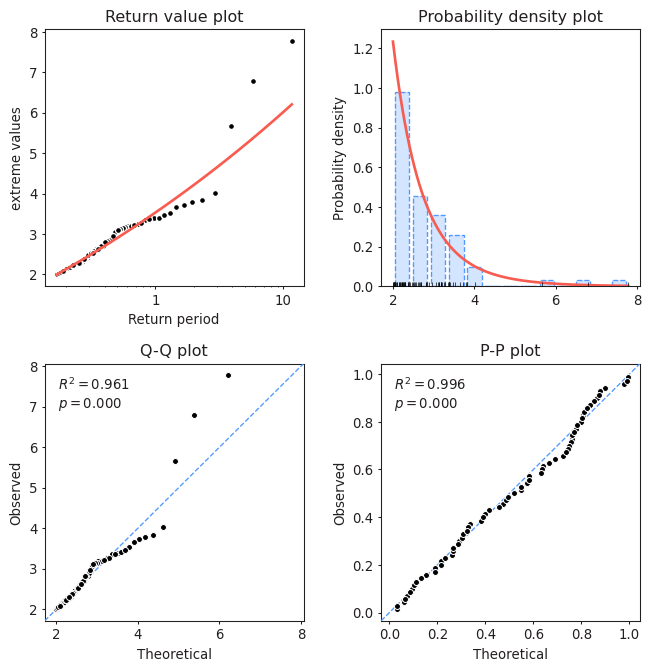

In [82]:
u_dynamic_doge = sorted_dynamic_doge[70]
#u_dynamic_doge = np.searchsorted(sorted_dynamic_doge, 2.25, side="left")
print(u_dynamic_doge)
params_dynamic_doge = modeling(standardized_resid, u_dynamic_doge)

In [87]:
VaR_dynamic_doge, ES_dynamic_doge = prediction(params_dynamic_doge, standardized_resid, u_dynamic_doge, 0.01)
VaR_return = VaR_dynamic_doge * results.conditional_volatility
print(VaR_return, ES_dynamic_doge)

Violation ratio:  0.016726403823178016
Date
2013-12-17     9.997499
2013-12-18    11.696516
2013-12-19    11.252702
2013-12-20    11.501015
2013-12-21    12.175569
                ...    
2025-05-31     1.383840
2025-06-01     1.327955
2025-06-02     1.275350
2025-06-03     1.226703
2025-06-04     1.181567
Name: cond_vol, Length: 4185, dtype: float64 8.571844250974632


2.309941995155195
{'LR_UC': 429.3248740237984, 'p-value_UC': 0.0, 'Reject_UC?': True, 'LR_IND': -0.0, 'p-value_IND': 1.0, 'Reject_IND?': False, 'LR_CC': 429.3248740237984, 'p-value_CC': 0.0, 'Reject_CC?': True, 'Violation Rate': 0.0, 'Expected Rate': 0.05, 'Transition Matrix': [[4184, 0], [0, 0]]}


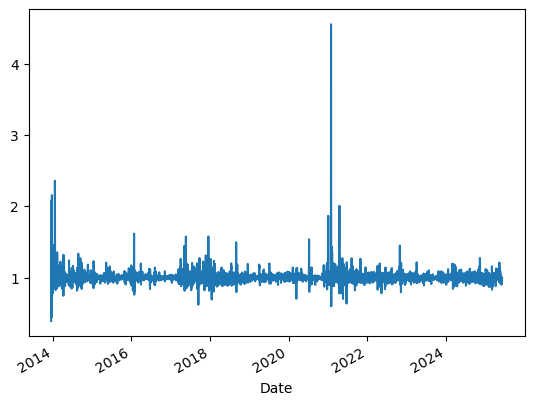

In [78]:
from scipy.stats import chi2

def unconditional_coverage_test(actual_returns, var_forecast, alpha=0.05):
    violations = (actual_returns < var_forecast).astype(int) #indicator function
    V = np.sum(violations) # No. of violations
    p = len(actual_returns) # Total observations
    k = V/p

    LR_statistic = -2 * np.log(k**V*(1-k)**(p-V)/(1-alpha)**V*alpha**(p-V))

    p_value = 1 - chi2.cdf(LR_statistic, df=1)

    reject_null = p_value < 0.05

    return LR_statistic, p_value, reject_null

def conditional_coverage_test(actual_returns, var_forecast, alpha=0.05):
    # Unconditional Coverage (UC) Test

    violations = (actual_returns > var_forecast).astype(int)
    #print(violations.head())
    n = len(violations)
    V = np.sum(violations)
    p_uc = V / n
    #print(actual_returns.head(), var_forecast, p_uc)
    LR_uc = -2 * np.log((alpha**V * (1 - alpha)**(n - V))) + 2 * np.log((p_uc**V * (1 - p_uc)**(n - V)))
    p_value_uc = 1 - chi2.cdf(LR_uc, df=1)
    
    # Independence (IND) Test
    # Count transitions: n_ij = transitions from state i to j (0=no violation, 1=violation)
    n00, n01, n10, n11 = 0, 0, 0, 0
    for t in range(1, n):
        prev, curr = violations[t-1], violations[t]
        if prev == 0 and curr == 0: n00 += 1
        elif prev == 0 and curr == 1: n01 += 1
        elif prev == 1 and curr == 0: n10 += 1
        elif prev == 1 and curr == 1: n11 += 1
    
    # Transition probabilities under H0 (independence)
    p01 = n01 / (n00 + n01) if (n00 + n01) > 0 else 0
    p11 = n11 / (n10 + n11) if (n10 + n11) > 0 else 0
    p_ind = (n01 + n11) / (n00 + n01 + n10 + n11)  # Marginal violation probability
    
    # Likelihoods
    L_ind = (1 - p_ind)**(n00 + n10) * p_ind**(n01 + n11)  # Independence
    L_actual = (1 - p01)**n00 * p01**n01 * (1 - p11)**n10 * p11**n11  # Observed
    
    LR_ind = -2 * np.log(L_ind / L_actual) if L_actual > 0 else 0
    p_value_ind = 1 - chi2.cdf(LR_ind, df=1)
    
    # Conditional Coverage (CC) Test
    LR_cc = LR_uc + LR_ind
    p_value_cc = 1 - chi2.cdf(LR_cc, df=2)
    
    # Decisions
    reject_uc = p_value_uc < 0.05
    reject_ind = p_value_ind < 0.05
    reject_cc = p_value_cc < 0.05
    
    return {
        "LR_UC": LR_uc,
        "p-value_UC": p_value_uc,
        "Reject_UC?": reject_uc,
        "LR_IND": LR_ind,
        "p-value_IND": p_value_ind,
        "Reject_IND?": reject_ind,
        "LR_CC": LR_cc,
        "p-value_CC": p_value_cc,
        "Reject_CC?": reject_cc,
        "Violation Rate": V / n,
        "Expected Rate": alpha,
        "Transition Matrix": [[n00, n01], [n10, n11]],
    }

doge_returns = doge_data / doge_data.shift(1).dropna()
doge_returns = doge_returns['Price']
doge_returns.index = pd.to_datetime(doge_returns.index)
converted_VaR_dynamic_doge = np.exp(VaR_dynamic_doge) - 1
print(VaR_dynamic_doge)
doge_returns.plot()
print(conditional_coverage_test(log_doge_returns, VaR_dynamic_doge, alpha=0.05)) # this should be untouched data


In [52]:
extremes = pyx.get_extremes(
    ts=std_resid,
    method="POT",
    threshold = 0.12
)
return_periods = pyx.get_return_periods(
    ts=std_resid,
    extremes=extremes,
    extremes_method="POT",
    extremes_type="high",
    return_period_size="365.2425D",
    plotting_position="weibull",
)
return_periods.sort_values("return period", ascending=False).head()

,extreme values,exceedance probability,return period
Date,,,
2021-01-28,18.097234,0.000947,11.474483
2019-04-01,7.603266,0.001894,5.737241
2021-01-02,6.832177,0.002841,3.824828
2020-07-08,6.513984,0.003788,2.868621
2022-10-29,6.359490,0.004735,2.294897
